<a href="https://colab.research.google.com/github/adithyans369/strawberry_model/blob/main/strawberry_growth_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!unzip -q dataset.zip

replace dataset/ripe/-6002-_jpg.rf.a257fc5e0eca91a8c26c5d10e410cfdf.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#NORMALIZATION
image_size = (224, 224)
batch_size = 32
data_dir = '/content/dataset'


datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 825 images belonging to 3 classes.
Found 205 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

#ADDING CLASSIFICATION LAYER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
outputs = Dense(9, activation='softmax',kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
print("Train classes:", train_generator.num_classes)
print("Validation classes:", val_generator.num_classes)


Train classes: 3
Validation classes: 3


In [10]:
print(train_generator.class_indices)


{'ripe': 0, 'turning': 1, 'unripe': 2}


In [11]:
import shutil

shutil.rmtree('/content/dataset/.git', ignore_errors=True)
print("Removed .git folder from dataset.")


Removed .git folder from dataset.


In [14]:
import tensorflow as tf

# Load pre-trained base model (example: MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model during initial training

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)  # ⚠️ Set to 3 classes

# Final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=25)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 570ms/step - accuracy: 0.7092 - loss: 0.7482 - val_accuracy: 0.5463 - val_loss: 0.8376
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8008 - loss: 0.5876 - val_accuracy: 0.6439 - val_loss: 0.7610
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.8236 - loss: 0.5316 - val_accuracy: 0.6878 - val_loss: 0.7239
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8311 - loss: 0.5172 - val_accuracy: 0.7122 - val_loss: 0.6888
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8595 - loss: 0.4644 - val_accuracy: 0.7415 - val_loss: 0.6643
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8639 - loss: 0.4136 - val_accuracy: 0.7512 - val_loss: 0.6418
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.8558 - loss: 0.4434 - val_accuracy: 0.7805 - val_loss: 0.6174
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8755 - loss: 0.3828 - val_accuracy: 0

In [16]:
model.save('/content/mobilenetv2_strawberry_classifier.h5')


In [17]:
from tensorflow.keras.models import load_model
model=load_model('/content/mobilenetv2_strawberry_classifier.h5')

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/img (914).png'#path of test image
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  #NORMALIZATION

In [20]:
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
print("Predicted class index:", predicted_class_index)
class_names = ['ripe', 'unripe', 'turning']
print("Predicted class:", class_names[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 2
Predicted class: turning


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class index: 2
Predicted class: turning


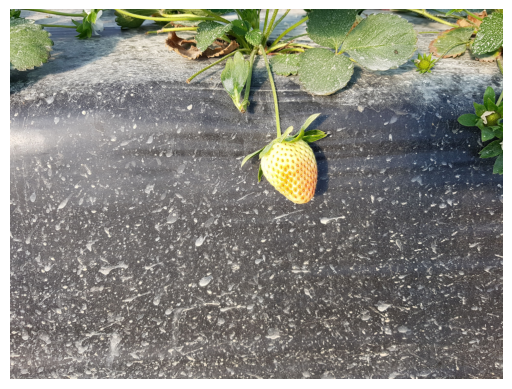

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
print("Predicted class index:", predicted_class_index)
class_names = ['ripe', 'unripe', 'turning']
print("Predicted class:", class_names[predicted_class_index])
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.show()